# Vitality Complexity Index (VCI) Implementation

## Objective
Translate clinical intuition into a programmable algorithm by implementing a variant of the LACE Index (Length of Stay, Acuity, Comorbidities, Emergency Visits).

## Scoring Logic
1. **L - Length of Stay Score**:
    * time_in_hospital < 1 day: 0 points
    * 1–4 days: 1 point
    * 5–13 days: 4 points
    * >= 14 days: 7 points
2. **A - Acuity of Admission Score**:
    * admission_type_id 1 (Emergency) or 7 (Trauma Center): 3 points
    * Others: 0 points
3. **C - Comorbidity Burden Score (Proxy)**:
    * number_diagnoses < 4: 0 points
    * 4–7 diagnoses: 3 points
    * >= 8 diagnoses: 5 points
4. **E - Emergency Visit Intensity Score**:
    * number_emergency 0: 0 points
    * 1–4 visits: 3 points
    * > 4 visits: 5 points

**Calculation**: VCI_Score = L + A + C + E

## Stratification
* **Low Risk**: VCI < 7
* **Medium Risk**: VCI 7–10
* **High Risk**: VCI > 10

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
file_path = '../data/processed/diabetic_data_enriched.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:

    print("Enriched data not found, checking raw data or alternative paths...")
    df = pd.read_csv('../data/processed/diabetic_data_clean.csv')

df.head()

Dataset loaded successfully.


C:\Users\Charuka\AppData\Local\Temp\ipykernel_14152\3870697215.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_desc,admission_source_desc,Primary_Diagnosis_Desc
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,NaN,...,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral,Other
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,NaN,...,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room,"Disorders of fluid, electrolyte, and acid-base..."
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,Other
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,NaN,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Other
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,NaN,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Other


In [3]:
# 1. L - Length of Stay Score
def calculate_L_score(days):
    if days < 1:
        return 0
    elif 1 <= days <= 4:
        return 1
    elif 5 <= days <= 13:
        return 4
    else: # >= 14
        return 7

df['L_Score'] = df['time_in_hospital'].apply(calculate_L_score)
print("L Score calculated.")

L Score calculated.


In [4]:
# 2. A - Acuity of Admission Score
# Emergency (1) or Trauma Center (7)
def calculate_A_score(admission_id):
    if admission_id in [1, 7]:
        return 3
    else:
        return 0

df['A_Score'] = df['admission_type_id'].apply(calculate_A_score)
print("A Score calculated.")

A Score calculated.


In [5]:
# 3. C - Comorbidity Burden Score (Proxy)
def calculate_C_score(diagnoses_count):
    if diagnoses_count < 4:
        return 0
    elif 4 <= diagnoses_count <= 7:
        return 3
    else: # >= 8
        return 5

df['C_Score'] = df['number_diagnoses'].apply(calculate_C_score)
print("C Score calculated.")

C Score calculated.


In [6]:
# 4. E - Emergency Visit Intensity Score
def calculate_E_score(emergency_visits):
    if emergency_visits == 0:
        return 0
    elif 1 <= emergency_visits <= 4:
        return 3
    else: # > 4
        return 5

df['E_Score'] = df['number_emergency'].apply(calculate_E_score)
print("E Score calculated.")

E Score calculated.


In [7]:
# Calculate Total VCI Score
df['VCI_Score'] = df['L_Score'] + df['A_Score'] + df['C_Score'] + df['E_Score']

# Stratify into Risk Categories
def stratify_risk(score):
    if score < 7:
        return 'Low Risk'
    elif 7 <= score <= 10:
        return 'Medium Risk'
    else: # > 10
        return 'High Risk'

df['Risk_Category'] = df['VCI_Score'].apply(stratify_risk)

# Display distribution
df['Risk_Category'].value_counts()

Risk_Category
Medium Risk    52023
Low Risk       28101
High Risk      19990
Name: count, dtype: int64

In [8]:
# Validation: Readmission Rate (<30) by Risk Category
# Create a binary column for readmitted < 30
df['readmitted_less_30'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Calculate rates
risk_analysis = df.groupby('Risk_Category')['readmitted_less_30'].mean() * 100

# Reorder for plotting logic
ordered_index = ['Low Risk', 'Medium Risk', 'High Risk']
risk_analysis = risk_analysis.reindex(ordered_index)

print(risk_analysis)

Risk_Category
Low Risk        8.807516
Medium Risk    11.414182
High Risk      14.727364
Name: readmitted_less_30, dtype: float64


C:\Users\Charuka\AppData\Local\Temp\ipykernel_14152\2803526625.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_analysis.index, y=risk_analysis.values, palette='viridis')


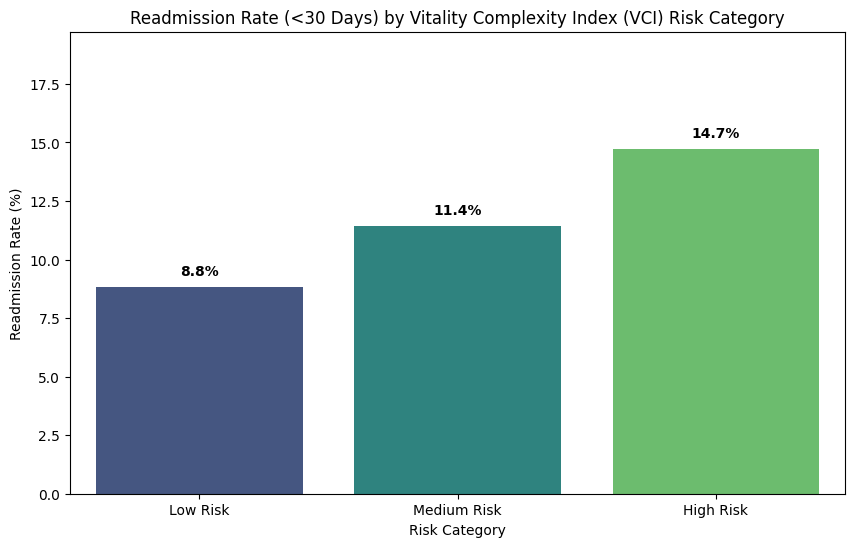

In [9]:
# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=risk_analysis.index, y=risk_analysis.values, palette='viridis')
plt.title('Readmission Rate (<30 Days) by Vitality Complexity Index (VCI) Risk Category')
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Risk Category')
plt.ylim(0, max(risk_analysis.values) + 5) # Add some headroom

for i, v in enumerate(risk_analysis.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()